Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

0 means that a female has non-diabetic and 1 means that a female is diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os
import random
import string
import sys

# sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, Normalizer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

import pickle

import wandb

import warnings
warnings.filterwarnings('ignore')

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [ ]:
wandb.login()

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']] = \
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']].replace(0, np.NaN)

In [5]:
imputer = KNNImputer(n_neighbors=2)
df_ = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

In [6]:
df_.columns = df_.columns.str.replace(' ', '_').str.lower()

In [7]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    float64
 1   glucose                   768 non-null    float64
 2   bloodpressure             768 non-null    float64
 3   skinthickness             768 non-null    float64
 4   insulin                   768 non-null    float64
 5   bmi                       768 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    float64
 8   outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


In [8]:
X = df_.drop(['outcome'], axis=1)
y = df_['outcome']

In [9]:
y.value_counts()

0.0    500
1.0    268
Name: outcome, dtype: int64

#### --- Ramdom Name

In [10]:
CONSONANTS = ''.join(string.ascii_lowercase)
NUMBERS = ''.join(string.digits)

def generate_word(length):
    word = ""
    for i in range(length):
        word += random.choice(CONSONANTS)
        word += random.choice(NUMBERS)
    return word

### Sampling

In [11]:
rus = RandomUnderSampler(sampling_strategy=1) 
X_res, y_res = rus.fit_resample(X, y)

In [12]:
y_res.value_counts()

0.0    268
1.0    268
Name: outcome, dtype: int64

In [13]:
ros = RandomOverSampler(sampling_strategy='not majority')
X_res2, y_res2 = ros.fit_resample(X, y)

In [14]:
y_res2.value_counts()

1.0    500
0.0    500
Name: outcome, dtype: int64

## Pipeline (GridSearchCV & Tuning)

In [15]:
kfold = KFold(n_splits=10, shuffle=True, random_state=10)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=43)

In [17]:
pipe_lr = Pipeline([('scaler', StandardScaler()),
                    ('clf', LogisticRegression(random_state=42))])

grid_params_lr = [{'scaler': [None, StandardScaler(), Normalizer()],
                   'clf__penalty': ['l1', 'l2'],
                   'clf__C': [0.01, 0.1, 1, 5, 10, 100],
                   'clf__penalty': ['l1', 'l2'],
                   'clf__class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}],
                 }]

grid_lr = GridSearchCV(pipe_lr, grid_params_lr, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [18]:
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('clf', KNeighborsClassifier())])

grid_params_knn = [{'scaler': [None, StandardScaler(), Normalizer()],
                    'clf__n_neighbors': [2, 5, 10, 25, 50]}]

grid_knn = GridSearchCV(pipe_knn, grid_params_knn, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [19]:
pipe_dt = Pipeline([('scaler', StandardScaler()),
                    ('clf', DecisionTreeClassifier(random_state=42))])

grid_params_dt = [{'scaler': [None, StandardScaler(), Normalizer()],
                   'clf__max_depth': [5, 10, 25, None],
                   'clf__min_samples_split': [2, 5, 10],
                   'clf__class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}],
  
                 }]

grid_dt = GridSearchCV(pipe_dt, grid_params_dt, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [20]:
pipe_rf = Pipeline([('scaler', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=42))])

grid_params_rf = [{'scaler': [None, StandardScaler(), Normalizer()],
                   'clf__n_estimators': [100, 300, 500, 1000],
                   'clf__max_depth': [3, 5, 10, 20, None],
                   'clf__max_features': [3, 5, 7],
                   'clf__class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}],
                 }]
            
grid_rf = GridSearchCV(pipe_rf, grid_params_rf, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [21]:
pipe_svc = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(probability=True, random_state=42))])

grid_params_svc = [{'scaler': [None, StandardScaler(), Normalizer()],
                    'clf__C': [10**-2, 10**-1, 10**0, 10**1, 10**2],
                    'clf__class_weight': [None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}],
                 }]
        
grid_svc = GridSearchCV(pipe_svc, grid_params_svc, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [22]:
pipe_gb = Pipeline([('scaler', StandardScaler()),
                    ('clf', GradientBoostingClassifier(random_state=42))])

grid_params_gb = [{'scaler': [None, StandardScaler(), Normalizer()],
                   'clf__learning_rate': [0.01, 0.1, 0.2, 1],
                   'clf__n_estimators': [100, 300, 500, 700],
                   'clf__max_depth': [3, 5, 10, 20],
                   'clf__min_samples_split': np.linspace(0.1, 0.5, 10),
                   'clf__subsample': [0.5, 0.9, 1.0],
                 }]

grid_gb = GridSearchCV(pipe_gb, grid_params_gb, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [23]:
pipe_lgbm = Pipeline([('scaler', StandardScaler()),
                      ('clf', LGBMClassifier())])

grid_params_lgbm = [{'scaler': [None, StandardScaler(), Normalizer()],
                     'clf__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.5],
                     'clf__n_estimators': [100, 500, 1000, 1500],
                     'clf__max_depth': [3,5,8],
                 }]

grid_lgbm = GridSearchCV(pipe_lgbm, grid_params_lgbm, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [24]:
pipe_nb = Pipeline([('scaler', StandardScaler()),
                    ('clf', MultinomialNB())])

grid_params_nb = [{'scaler': [None, StandardScaler(), Normalizer()],
                   'clf__alpha': [0.1, 1],
                   'clf__fit_prior': [True, False],
                 }]

grid_nb = GridSearchCV(pipe_nb, grid_params_nb, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

In [26]:
grids = [grid_lr, grid_knn, grid_dt, grid_rf, grid_svc, grid_gb, grid_lgbm, grid_nb]

grid_dict = {0: 'Logistic Regression', 
             1: 'KNeighbors',
             2: 'Decision Tree',
             3: 'Random Forest',
             4: 'SVC',
             5: 'Gradient Boosting',
             6: 'LGBM',
             7: 'Naive Bayes'}

In [27]:
labels = np.array([0, 1])
#labels = np.array(['positive', 'negative'])
labels

array([0, 1])

In [28]:
feature_names = np.array(X.columns)
feature_names

array(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness',
       'insulin', 'bmi', 'diabetespedigreefunction', 'age'], dtype=object)

In [31]:
best_acc = 0.0
best_clf = 0
best_gs = ''

train_results = []
test_results = []
names = []

for idx, gs in enumerate(grids):
    run = wandb.init(project='ml-diabetesexample', name=grid_dict[idx])
    print('\nEstimator: %s' % grid_dict[idx])

    # Fit
    gs.fit(X_train, y_train)
    print('Best params: %s' % gs.best_params_)
    print('Training accuracy: %.3f' % gs.best_score_)
    
    # Predict 
    y_pred = gs.predict(X_test)
    y_probas = gs.predict_proba(X_test)
    print('Test accuracy: %.3f ' % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Track results
    train_results.append(gs.best_score_)
    test_results.append(accuracy_score(y_test, y_pred))
    names.append(grid_dict[idx])
    
    # wandb
    modelname = generate_word(5) + '.pkl'
    pickle.dump(gs, open(os.path.join(wandb.run.dir, modelname), 'wb'))
    filename = os.path.join(wandb.run.dir, modelname)
    
    wandb.config.update(gs.best_params_)
    wandb.config.filemodel = wandb.run.dir + '/' + modelname
    wandb.config.train_acc = gs.best_score_
    wandb.config.test_acc = accuracy_score(y_test, y_pred)
    
    wandb.sklearn.plot_classifier(gs, 
                              X_train, X_test, 
                              y_train, y_test, 
                              y_pred, y_probas, 
                              labels, 
                              is_binary=True, 
                              model_name=grid_dict[idx],
                              feature_names=feature_names)
    
    wandb.finish()

    # Track best model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
        
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])


Estimator: Logistic Regression
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best params: {'clf__C': 1, 'clf__class_weight': None, 'clf__penalty': 'l2', 'scaler': StandardScaler()}
Training accuracy: 0.764
Test accuracy: 0.694 
              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72        53
         1.0       0.75      0.60      0.67        55

    accuracy                           0.69       108
   macro avg       0.70      0.70      0.69       108
weighted avg       0.70      0.69      0.69       108


Estimator: KNeighbors
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best params: {'clf__n_neighbors': 5, 'scaler': StandardScaler()}
Training accuracy: 0.762
Test accuracy: 0.769 
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77        53
         1.0       0.79      0.75      0.77        55

    accuracy                           0.77       108
   macro 

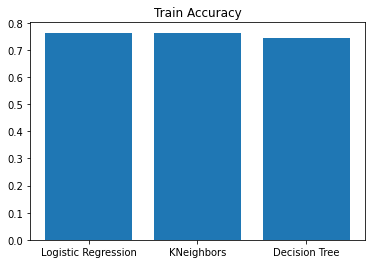

In [32]:
plt.bar(names, train_results)
plt.title('Train Accuracy')
plt.show()

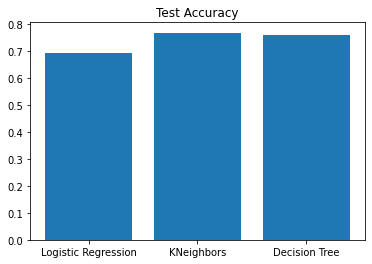

In [33]:
plt.bar(names, test_results)
plt.title('Test Accuracy')
plt.show()